In [1]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from pathlib import Path
from matplotlib.patches import Patch

In [2]:
paths_to_folds_results = {
    "default": {
        "fold_0": "resources/default-normalization/nnUNetTrainer__nnUNetPlans__3d_fullres/fold_0/summary.json",
        "fold_1": "resources/default-normalization/nnUNetTrainer__nnUNetPlans__3d_fullres/fold_1/summary.json",    
        "fold_2": "resources/default-normalization/nnUNetTrainer__nnUNetPlans__3d_fullres/fold_2/summary.json",
        "fold_3": "resources/default-normalization/nnUNetTrainer__nnUNetPlans__3d_fullres/fold_3/summary.json",
        "fold_4": "resources/default-normalization/nnUNetTrainer__nnUNetPlans__3d_fullres/fold_4/summary.json"
    },
    "windowing": {
        "fold_0": "resources/windowing-normalization/nnUNetTrainer__nnUNetPlans__3d_fullres/fold_0/summary.json",
        "fold_1": "resources/windowing-normalization/nnUNetTrainer__nnUNetPlans__3d_fullres/fold_1/summary.json",    
        "fold_2": "resources/windowing-normalization/nnUNetTrainer__nnUNetPlans__3d_fullres/fold_2/summary.json",
        "fold_3": "resources/windowing-normalization/nnUNetTrainer__nnUNetPlans__3d_fullres/fold_3/summary.json",
        "fold_4": "resources/windowing-normalization/nnUNetTrainer__nnUNetPlans__3d_fullres/fold_4/summary.json"
    }
}
paths_to_test_results = {
    "windowing": "/media/robber/Nuevo vol1/nnUNet/notebooks/3/resources/windowing-normalization/nnUNetTrainer__nnUNetPlans__3d_fullres/test-set/performance.csv"
}
labels_mapping = {
    "1": "tumor",
    "2": "adenopathy"
}

In [3]:
new_metrics_per_case = []
for normalization_scheme, results_dict in paths_to_folds_results.items():
    for fold, path in results_dict.items():
        with open(path, 'r') as file:
            results = json.load(file)
        new_metrics_per_case += [
            {
                "normalization": normalization_scheme,
                "fold": fold.split('_')[-1],
                "prediction_file": item["prediction_file"],
                "reference_file": item["reference_file"],
                "filename": Path(item["reference_file"]).name,
                "class_label": class_,
                "class_name": labels_mapping.get(class_),
                **metrics
            }
            for item in results['metric_per_case']
            for class_, metrics in item["metrics"].items()
        ]

In [4]:
new_metrics_per_case_df = pd.DataFrame(new_metrics_per_case)
#display(new_metrics_per_case_df)
new_metrics_per_case_df.to_csv(
    "metrics_per_case.csv",
    index=False
)

# Desempeño en conjunto de Validación

## Desempeño medido sobre cada CT de Validación
- Se reporta el coeficiente Dice para cada CT de validación, obtenido con el modelo del fold correspondiente.
- Validación Cruzada 5 fold: cada CT es evaluado una sola vez en el conjunto de validación.
- Total de imágenes: 24 CTs.
- Esta forma de medir el desempeño es susceptible a CTs mal segmentados, aun cuando el tamaño de la lesión es pequeño. El desempeño final medido cae drásticamente si existen CTs con coeficiente Dice cercano a 0. 

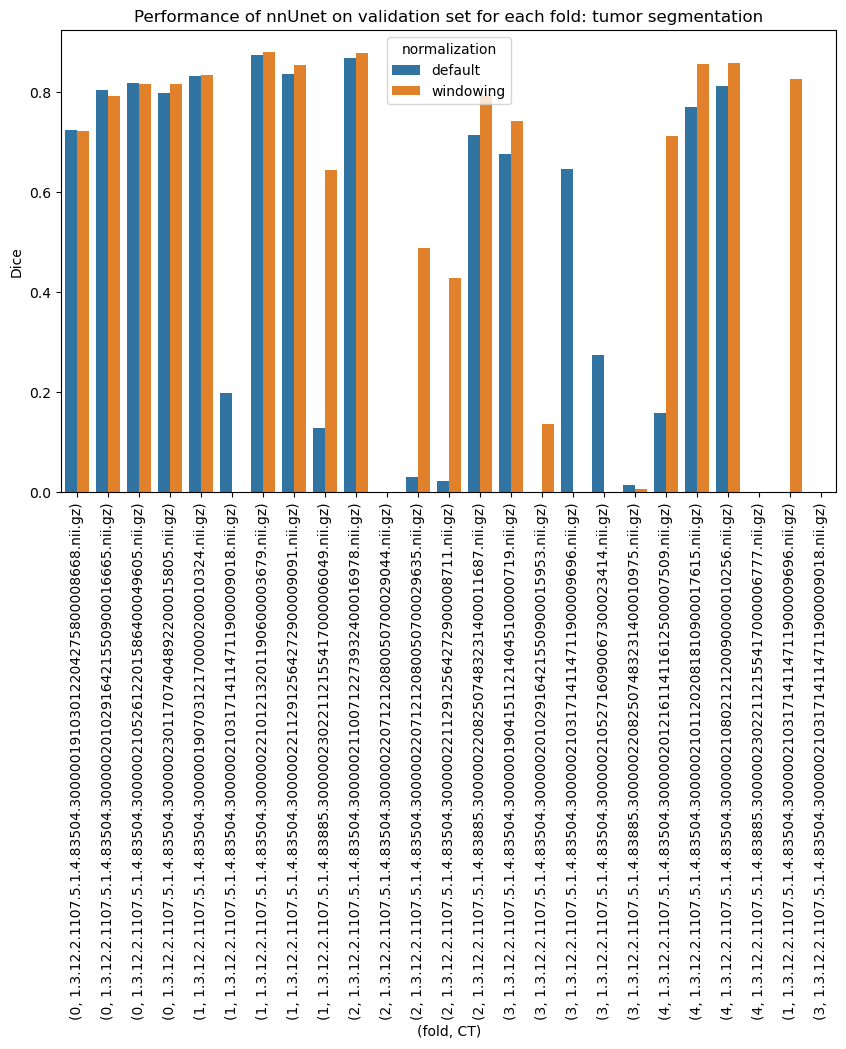

In [5]:
new_df_tumor = new_metrics_per_case_df[(new_metrics_per_case_df["class_name"] == "tumor") & (new_metrics_per_case_df["n_ref"] > 0) ].copy()
new_df_tumor['fold_filename'] = new_df_tumor.apply(lambda row: f"({row['fold']}, {row['filename']})", axis=1)
plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
ax = sns.barplot(
    data=new_df_tumor,
    x='fold_filename',
    y='Dice',
    hue='normalization',
    dodge=True
)
plt.xlabel("(fold, CT)")
plt.legend(title="normalization")
plt.xticks(rotation=90, ha="center")
plt.title("Performance of nnUnet on validation set for each fold: tumor segmentation")
plt.show()

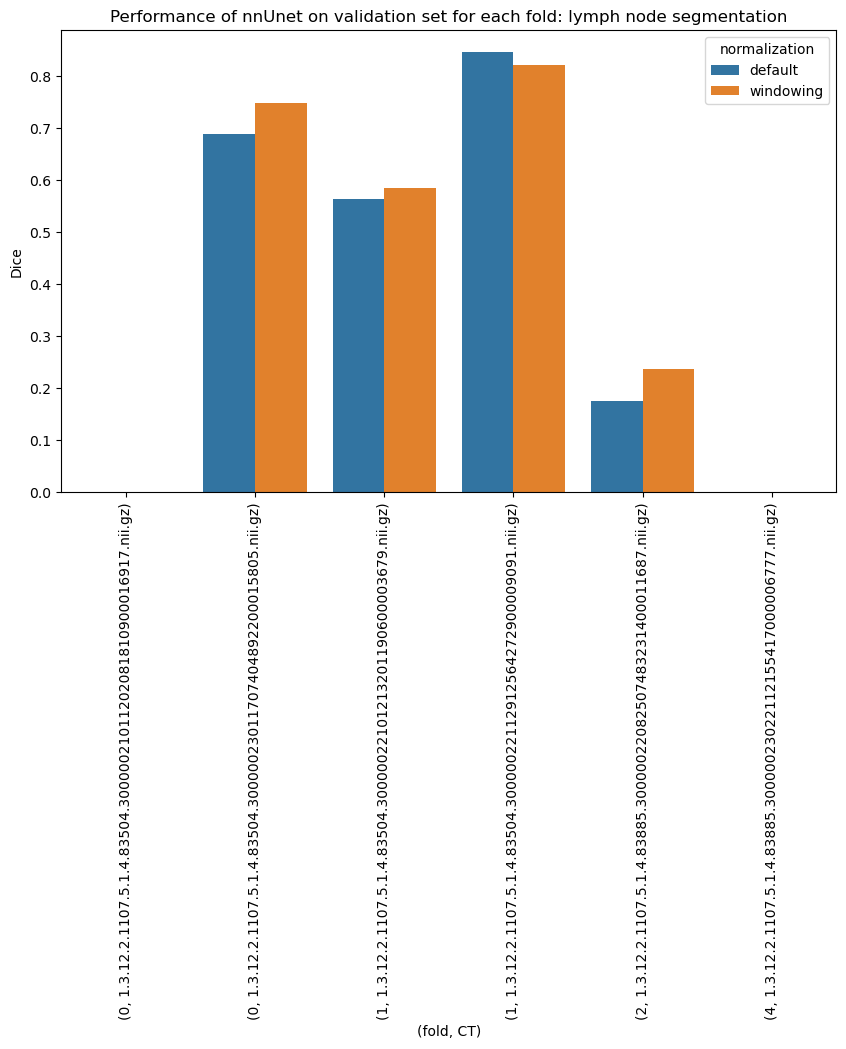

In [6]:
new_df_adenopathy = new_metrics_per_case_df[(new_metrics_per_case_df["class_name"] == "adenopathy") & (new_metrics_per_case_df["n_ref"] > 0)].copy()
new_df_adenopathy['fold_filename'] = new_df_adenopathy.apply(lambda row: f"({row['fold']}, {row['filename']})", axis=1)
plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
ax = sns.barplot(
    data=new_df_adenopathy,
    x='fold_filename',
    y='Dice',
    hue='normalization',
    dodge=True
)
plt.xlabel("(fold, CT)")
plt.legend(title="normalization")
plt.xticks(rotation=90, ha="center")
plt.title("Performance of nnUnet on validation set for each fold: lymph node segmentation")
plt.show()

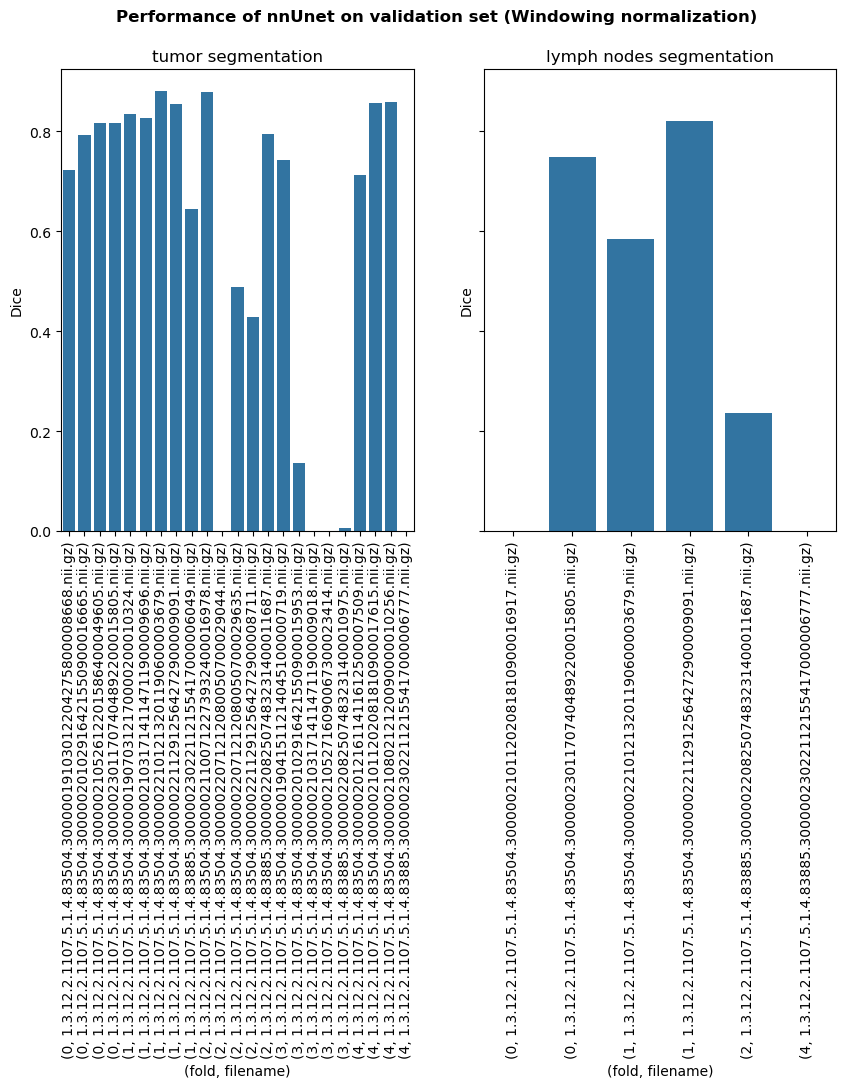

In [7]:
normalization = 'windowing'
_, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,6), sharey=True)
sns.barplot(
    data=new_df_tumor[new_df_tumor['normalization'] == normalization],
    x='fold_filename',
    y='Dice',
    color='tab:blue',
    ax=ax[0]
)
sns.barplot(
    data=new_df_adenopathy[new_df_adenopathy['normalization'] == normalization],
    x='fold_filename',
    y='Dice',
    color='tab:blue',
    ax=ax[1]
)
ax[0].tick_params(rotation=90, axis='x')
ax[1].tick_params(rotation=90, axis='x')
ax[0].set_title('tumor segmentation')
ax[1].set_title('lymph nodes segmentation')
ax[0].set_xlabel('(fold, filename)')
ax[1].set_xlabel('(fold, filename)')
plt.suptitle("Performance of nnUnet on validation set (Windowing normalization)", weight='bold')
plt.show()

In [8]:
grouped = new_metrics_per_case_df.groupby(["normalization", "fold", "class_name"])["Dice"].agg(["mean", "std"]).reset_index()
display(grouped)

,normalization,fold,class_name,mean,std
0,default,0,adenopathy,0.345050,0.487975
1,default,0,tumor,0.629459,0.353774
2,default,1,adenopathy,0.352937,0.423465
3,default,1,tumor,0.574633,0.376650
4,default,2,adenopathy,0.087963,0.124398
5,default,2,tumor,0.327204,0.427576
6,default,3,adenopathy,NaN,NaN
7,default,3,tumor,0.322421,0.329024
8,default,4,adenopathy,0.000000,0.000000
9,default,4,tumor,0.435556,0.416752


In [9]:
grouped = new_metrics_per_case_df.groupby(["normalization", "class_name"])["Dice"].agg(["mean", "std"]).reset_index()
display(grouped)

,normalization,class_name,mean,std
0,default,adenopathy,0.227777,0.337407
1,default,tumor,0.458784,0.369953
2,windowing,adenopathy,0.398528,0.368665
3,windowing,tumor,0.545609,0.362373


## Desempeño agregado sobre todos los CTs de Validación
- Se suman los TP, FP y FN de todas las series evaluadas, y con los valores acumulados se calcula el coeficiente de Dice.
- Esta modalidad de evaluación no penaliza CTs indivuales mal segmentados.

In [10]:
def get_aggregated_metrics(df):
    TP = df["TP"].sum()
    FP = df["FP"].sum()
    FN = df["FN"].sum()
    dice = 2*TP / (2*TP + FP + FN)
    metrics = {
        "TP": TP,
        "FP": FP,
        "FN": FN,
        "dice": dice
    }
    return metrics

In [11]:
aggregated_metrics_df = []
for normalization, class_name in itertools.product(
    new_metrics_per_case_df["normalization"].unique().tolist(),
    new_metrics_per_case_df["class_name"].unique().tolist()
):
    agg_metrics = get_aggregated_metrics(
        new_metrics_per_case_df[
            (new_metrics_per_case_df["normalization"] == normalization) &
            (new_metrics_per_case_df["class_name"] == class_name)
        ]
    )
    aggregated_metrics_df.append(
        {
            "normalization": normalization,
            "class_name": class_name,
            **agg_metrics
        }
    )
aggregated_metrics_df = pd.DataFrame(aggregated_metrics_df)
display(aggregated_metrics_df)

,normalization,class_name,TP,FP,FN,dice
0,default,tumor,974011,559988,592778,0.628235
1,default,adenopathy,26884,21637,79967,0.346060
2,windowing,tumor,1169438,273929,397493,0.776958
3,windowing,adenopathy,29788,13042,77063,0.398020


# Desempeño en conjunto de Test
- La inferencia del pipeline nnUnet se realiza mediante el ensamble formado por los 5 modelos obtenidos en la Validación Cruzada 5-fold.
- Total de imágenes: 15

## Desempeño medido sobre cada CT de test

In [12]:
test_results_df = pd.DataFrame(
    [
        {
            "normalization": normalization,
            "filename": Path(item["path_to_gt"]).name,
            **item
        }
        for normalization, path in paths_to_test_results.items()
        for item in pd.read_csv(path).to_dict(orient='records')
    ]
)
cts_with_tumor = test_results_df[(test_results_df["label_name"] == 'tumor') & (test_results_df["n_ref"] > 0) ]['filename'].unique().tolist()
cts_with_adenopathy = test_results_df[(test_results_df["label_name"] == 'adenopathy') & (test_results_df["n_ref"] > 0) ]['filename'].unique().tolist()
print(f"CTs with tumor annotations: {len(cts_with_tumor)}")
display(cts_with_tumor)
print(f"CTs with adenopathy annotations: {len(cts_with_adenopathy)}")
display(cts_with_adenopathy)

CTs with tumor annotations: 8


['1.3.12.2.1107.5.1.4.83504.30000021051412400662100001857.nii.gz',
 '1.3.12.2.1107.5.1.4.83504.30000021051412400662100001523.nii.gz',
 '1.3.12.2.1107.5.1.4.83504.30000021070712131706800023856.nii.gz',
 '1.3.12.2.1107.5.1.4.83504.30000021071911510369800020299.nii.gz',
 '1.3.12.2.1107.5.1.4.83504.30000021091312134713400002616.nii.gz',
 '1.3.12.2.1107.5.1.4.83504.30000023032112314560600032721.nii.gz',
 '1.3.12.2.1107.5.1.4.83885.30000023052212224943100007846.nii.gz',
 '1.3.12.2.1107.5.1.4.83504.30000023072011471461300015769.nii.gz']

CTs with adenopathy annotations: 9


['1.3.12.2.1107.5.1.4.83504.30000021051412400662100001857.nii.gz',
 '1.3.12.2.1107.5.1.4.83504.30000021061509140333600009084.nii.gz',
 '1.3.12.2.1107.5.1.4.83504.30000020011313523232500004258.nii.gz',
 '1.3.12.2.1107.5.1.4.83504.30000020040114181387500000788.nii.gz',
 '1.3.12.2.1107.5.1.4.83504.30000020021012090131800013364.nii.gz',
 '1.3.12.2.1107.5.1.4.83504.30000021071911510369800020299.nii.gz',
 '1.3.12.2.1107.5.1.4.83504.30000017121507082014000029608.nii.gz',
 '1.3.12.2.1107.5.1.4.83504.30000021082509324422300004131.nii.gz',
 '1.3.12.2.1107.5.1.4.83504.30000021102712332815800004663.nii.gz']

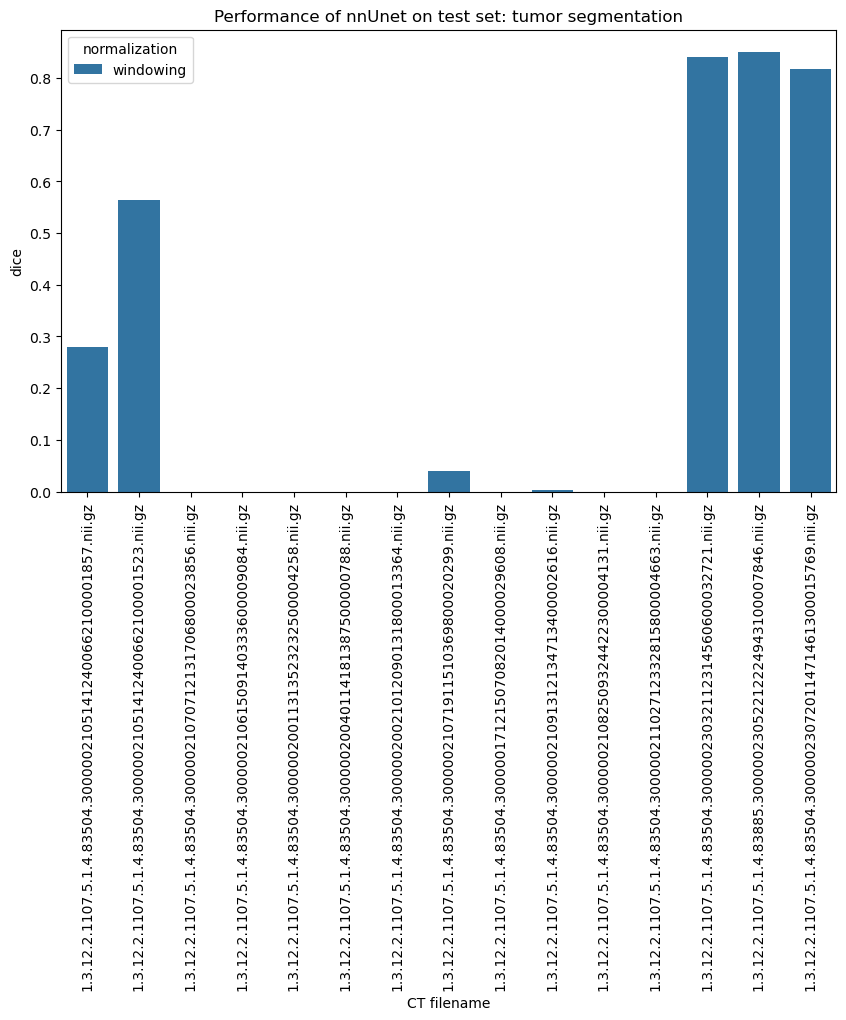

In [13]:
new_df = test_results_df[test_results_df["label_name"] == 'tumor']
plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
ax = sns.barplot(
    data=new_df,
    x='filename',
    y='dice',
    hue='normalization',
    dodge=True
)
plt.xlabel("CT filename")
plt.legend(title="normalization")
plt.xticks(rotation=90, ha="center")
plt.title("Performance of nnUnet on test set: tumor segmentation")
plt.show()

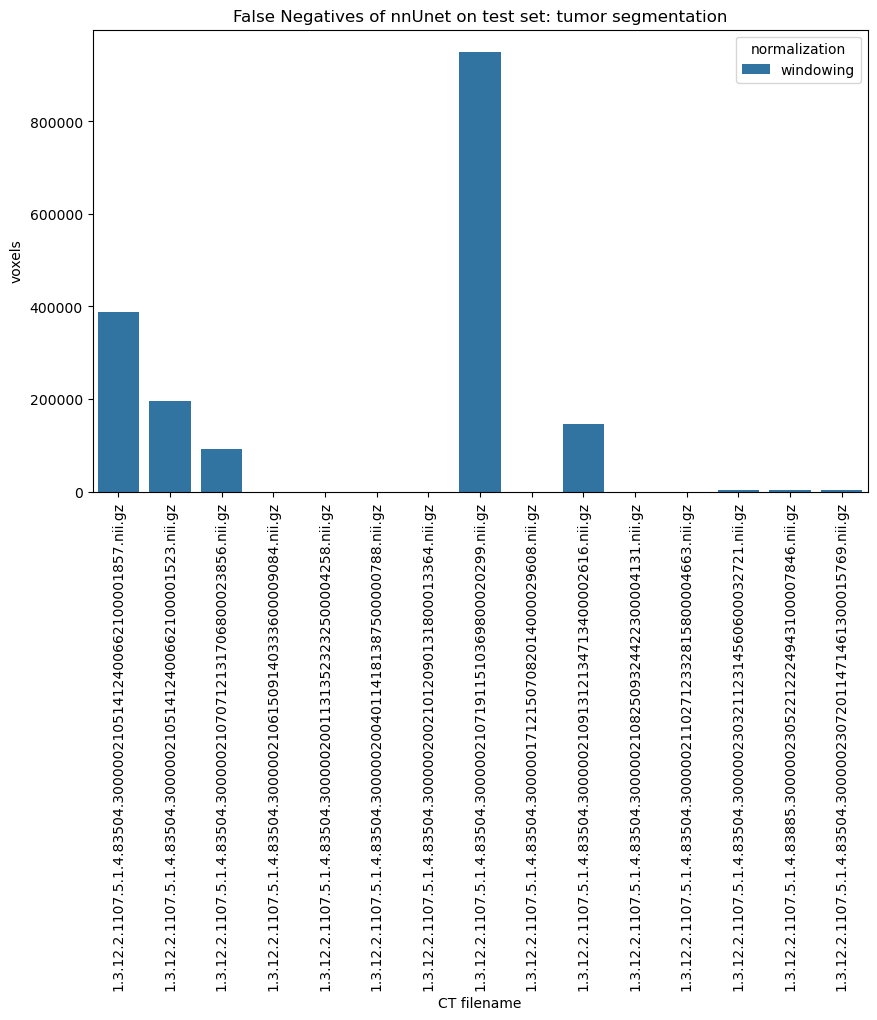

In [14]:
new_df = test_results_df[test_results_df["label_name"] == 'tumor']
plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
ax = sns.barplot(
    data=new_df,
    x='filename',
    y='FN',
    hue='normalization',
    dodge=True
)
plt.xlabel("CT filename")
plt.ylabel("voxels")
plt.legend(title="normalization")
plt.xticks(rotation=90, ha="center")
plt.title("False Negatives of nnUnet on test set: tumor segmentation")
plt.show()

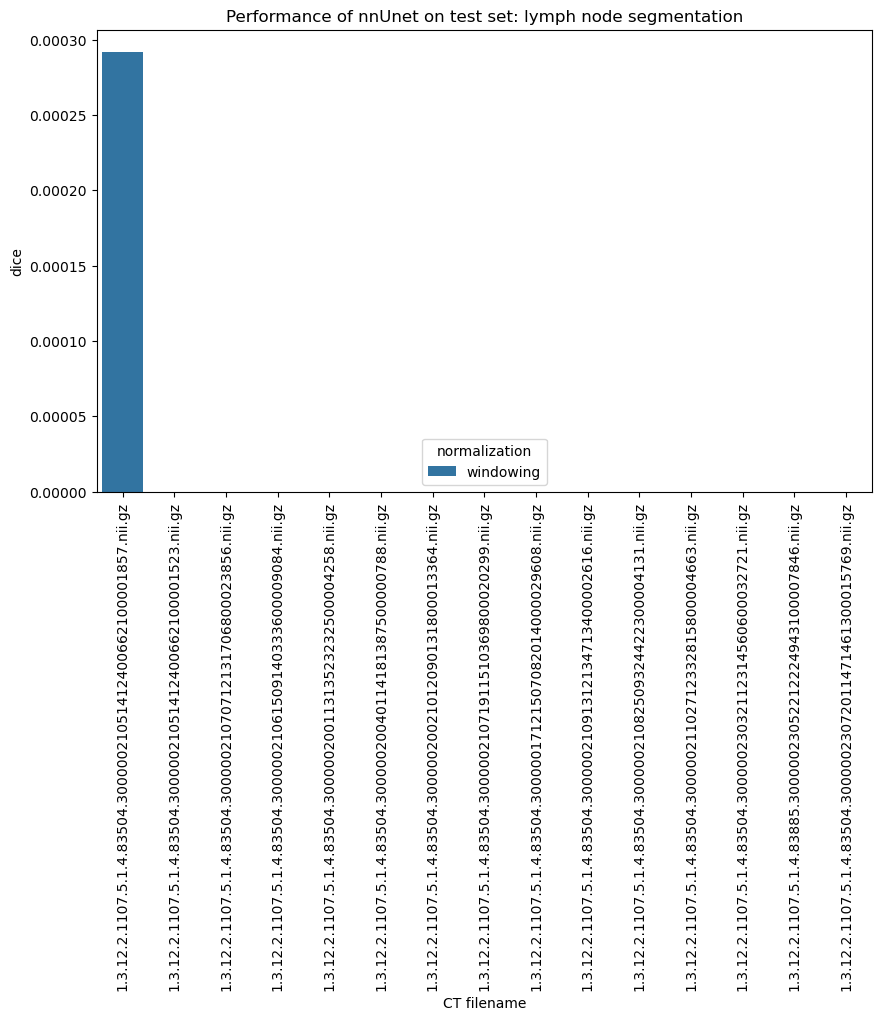

In [15]:
new_df = test_results_df[test_results_df["label_name"] == 'adenopathy']
plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
ax = sns.barplot(
    data=new_df,
    x='filename',
    y='dice',
    hue='normalization',
    dodge=True
)
plt.xlabel("CT filename")
plt.legend(title="normalization")
plt.xticks(rotation=90, ha="center")
plt.title("Performance of nnUnet on test set: lymph node segmentation")
plt.show()

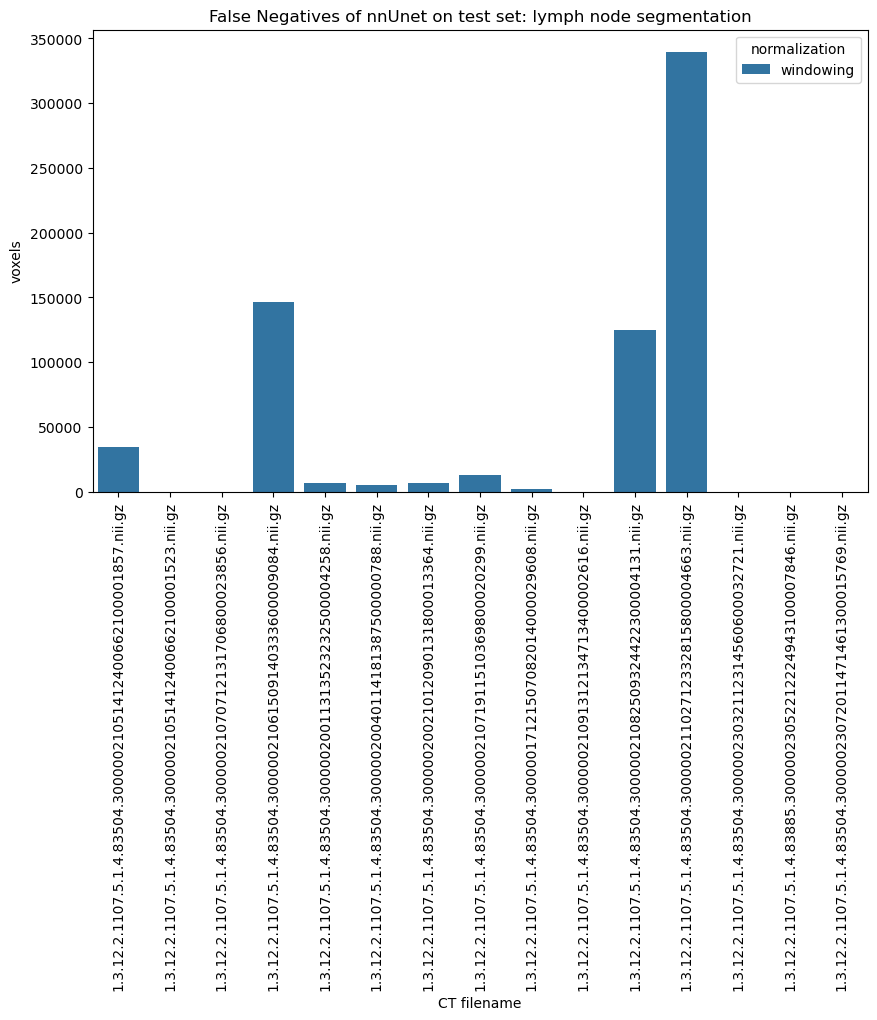

In [16]:
new_df = test_results_df[test_results_df["label_name"] == 'adenopathy']
plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
ax = sns.barplot(
    data=new_df,
    x='filename',
    y='FN',
    hue='normalization',
    dodge=True
)
plt.xlabel("CT filename")
plt.ylabel("voxels")
plt.legend(title="normalization")
plt.xticks(rotation=90, ha="center")
plt.title("False Negatives of nnUnet on test set: lymph node segmentation")
plt.show()

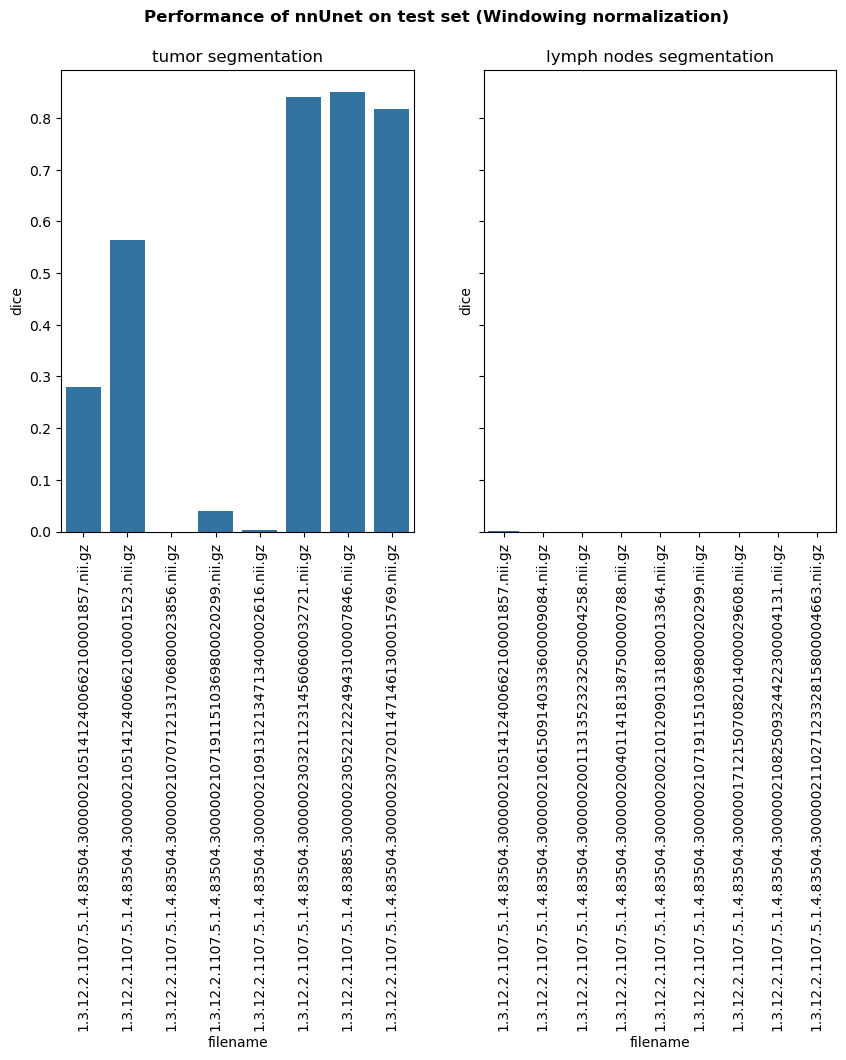

In [17]:
normalization = 'windowing'
_, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,6), sharey=True)
sns.barplot(
    data=test_results_df[
        (test_results_df['normalization'] == normalization) &
        (test_results_df['label_name'] == 'tumor') &
        (test_results_df['n_ref'] > 0)],
    x='filename',
    y='dice',
    color='tab:blue',
    ax=ax[0]
)
sns.barplot(
    data=test_results_df[
        (test_results_df['normalization'] == normalization) &
        (test_results_df['label_name'] == 'adenopathy') &
        (test_results_df['n_ref'] > 0)],
    x='filename',
    y='dice',
    color='tab:blue',
    ax=ax[1]
)
ax[0].tick_params(rotation=90, axis='x')
ax[1].tick_params(rotation=90, axis='x')
ax[0].set_title('tumor segmentation')
ax[1].set_title('lymph nodes segmentation')
ax[0].set_xlabel('filename')
ax[1].set_xlabel('filename')
plt.suptitle("Performance of nnUnet on test set (Windowing normalization)", weight='bold')
plt.show()

In [18]:
grouped = test_results_df.groupby(['normalization', 'label_name'])['dice'].agg(['mean', 'std']).reset_index()
display(grouped)

,normalization,label_name,mean,std
0,windowing,adenopathy,0.000032,0.000097
1,windowing,tumor,0.423989,0.388420


## Desempeño agregado sobre todos los CTs de Test

In [19]:
aggregated_metrics_df = []
for normalization, class_name in itertools.product(
    test_results_df["normalization"].unique().tolist(),
    test_results_df["label_name"].unique().tolist()
):
    agg_metrics = get_aggregated_metrics(
        test_results_df[
            (test_results_df["normalization"] == normalization) &
            (test_results_df["label_name"] == class_name)
        ]
    )
    aggregated_metrics_df.append(
        {
            "normalization": normalization,
            "class_name": class_name,
            **agg_metrics
        }
    )
aggregated_metrics_df = pd.DataFrame(aggregated_metrics_df)
display(aggregated_metrics_df)

,normalization,class_name,TP,FP,FN,dice
0,windowing,tumor,308414,56876,1784126,0.250964
1,windowing,adenopathy,5,83,678484,0.000015
